# Quora questions similarity. 

**Goal:** find similarity of question pairs.

**Methods:** one-shot learning using neural networks with time distributed and LSTM layers. Question embedding was done using pre-trained GloVe embeddings. 

**Dataset info:** 

Total number of questions pairs: 404,278

Maximum question length, question 1: 125

Maximum question length, question 2: 237

Median number of words per question: 10

Vocabulary size: 232531

**Similarity metrics:**

- Jaccard similarity, based on characters and words. 

- Cosine similarity between questions, based on words.

The Jaccard similarity index compares members for two sets to see which members are shared and which are distinct. It's a measure of similarity for the two sets of data, with a range from 0% to 100%. 

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.

**Preprocessing workflow.**

- Tokenize dataset.

- Limit the number of words considered per question to a certain number (20 in this notebook).

- Generate an embedding matrix using pre-trained embeddings using GloVe with 50 dimensions per word.

**One-shot learning using a Siamese network with time distributed layers.**

- Add embedding layers for each question and then time distributed layers for each question. 

The time distributed layer applies a dense layer to every temporal slice of an input. The input should be at least 3D, and the dimension of index one will be considered to be the temporal dimension. Consider a batch of 32 samples, where each sample is a sequence of 10 vectors of 16 dimensions. The batch input shape of the layer is then (32, 10, 16), and the input_shape, not including the dimension of the sample, is (10, 16).

- To precalculated similarity features (cosine similarity on words, Jaccard similarity on characters and words) add features equivalent to finding the most similar words in question pairs (max value along the embedding vector in the tensor for each question) and average similarity of question pairs (sum of values along the dimension in the tensor corresponding to the sequence of words in each question).

**One-shot learning using a Siamese network with LSTM layers.**

- Add LSTM layers, since this is a siamese network, both inputs (questions) share the same LSTM.

- Combine the LSTM layers output using the Manhattan distance metric and add it to precalculated similarity features. 

**Comparison of perfomance of the above two networks on the test data:**

| **Time distributed** |precision | recall  | f1-score |
|------------------|----------|---------|----------|
|not similar       |   0.82   |  0.84   |  0.83    |
|   similar        |   0.72   |  0.68   |  0.70    |
|   accuracy       |          |         |  0.78    |


| **LSTM** |precision | recall  | f1-score |
|------------------|----------|---------|----------|
|not similar       |   0.81   |  0.87   |  0.84    |
|   similar        |   0.75   |  0.65   |  0.69    |
|   accuracy       |          |         |  0.79    |


In [1]:
%matplotlib inline
%tensorflow_version 1.x
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json

from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf 
from sklearn.metrics import roc_auc_score
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import functools
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
print(tf.__version__)

1.15.0


In [0]:
def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        ''' Wrapper for turning tensorflow metrics into keras metrics '''
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [0]:
def classification_and_confusion_report(actual_label,predicted_label,threshold):
    ''' Compute confusion matrix and classification report for 
    given actual and predicted labels. '''
    predicted_label = np.where(predicted_label>threshold,1,0)
    report=classification_report(actual_label,predicted_label)
    cm = confusion_matrix(actual_label,predicted_label)
    print(cm)
    print(report)

#Importing dataset.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
question_pairs = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/capstone2/quora_questions_similarity/train.csv')
question_pairs.dropna(axis=0,
                      inplace=True)

In [7]:
question_pairs.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


#Parameters.

In [0]:
MAX_SEQUENCE_LENGTH=20
                         
NB_WORDS = 1500          
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
NB_EPOCHS = 10
DROPOUT = 0.1
BATCH_SIZE = 32

#Getting some basic informaion about the dataset.

In [9]:
print('Total number of entries: ', question_pairs.shape[0])

Total number of entries:  404287


In [0]:
question1_length = [len(q.split()) for q in question_pairs.question1]
question2_length = [len(q.split()) for q in question_pairs.question2]

max_question1_length = max(question1_length)
max_question2_length = max(question2_length)

In [11]:
print('Maximum question length in question 1:', max_question1_length)
print('Maximum question length in question 2:',max_question2_length)

Maximum question length in question 1: 125
Maximum question length in question 2: 237


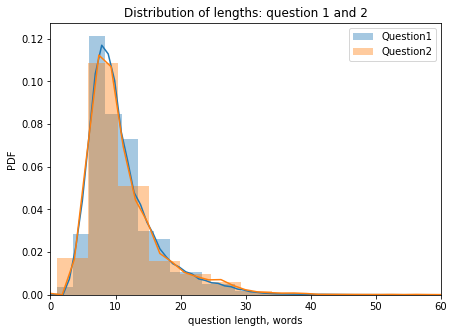

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.distplot(question1_length,
                  kde=True, 
                  hist = True,
                  label = 'Question1')

ax = sns.distplot(question2_length,
                  kde=True, 
                  hist = True,
                  label = 'Question2')

ax.set(xlabel='question length, words', ylabel='PDF', 
       title = 'Distribution of lengths: question 1 and 2')
ax.set_xlim(0,60)

plt.legend()
plt.show()

In [13]:
word_counts = Counter()

question1 = question_pairs.question1.values.tolist()

for q in question_pairs.question1:
    words = q.split()
    word_counts.update(words)

for q in question_pairs.question2:
    words = q.split()
    word_counts.update(words)
    
print('Vocabulary size:', len(word_counts))

Vocabulary size: 232531


#Jaccard and Cosine similarity.

In [0]:
def match_count(q1,q2):
    ''' Returns Jaccard similarity of two datasets. '''
    set_1 = set(q1)
    set_2 = set(q2)
    set_3 = set_1.intersection(set_2)
    return len(set_3)/(len(set_1)+len(set_2)-len(set_3))  

In [0]:
# Create two additional columns in the question_pairs dataframe: 
# character match count and word match count using match_count(q1,q2) function 
# defined above.
question_pairs.question1 = question_pairs.question1.str.lower()
question_pairs.question2 = question_pairs.question2.str.lower()

question_pairs['char_match_count']= \
    question_pairs.apply(lambda row: match_count(row['question1'],row['question2']),
                         axis=1)
question_pairs['word_match_count'] = \
    question_pairs.apply(lambda row: match_count(row['question1'].split(),row['question2'].split()),
                         axis=1)

In [0]:
import re, math
from collections import Counter

def get_cosine(vec1, vec2):
    ''' Calculate cosine similarity between two vectors,
    each vector is dictionary with key and value word:count.'''
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = re.compile(r'\w+').findall(text)
    return Counter(words)

In [0]:
# Add column containing cosien similarity of question pairs.
question_pairs['cosine_similarity']= \
    question_pairs.apply(lambda row: get_cosine(text_to_vector(row['question1']),
                                       text_to_vector(row['question2'])), axis=1)

In [18]:
question_pairs.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,char_match_count,word_match_count,cosine_similarity
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1.000000,0.769231,0.944911
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,0.703704,0.250000,0.613572
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.750000,0.200000,0.338062


# Distributions of text similarity metrics.

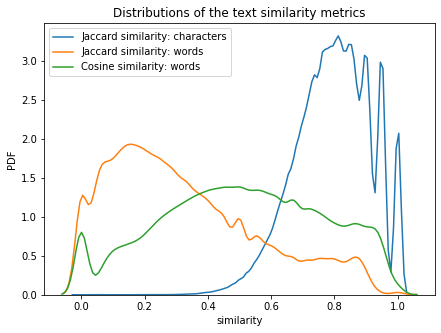

In [19]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.distplot(question_pairs.char_match_count, 
                  bins=int(np.sqrt(len(question_pairs.char_match_count))), 
                  kde=True, 
                  hist = False,
                  label = 'Jaccard similarity: characters')
ax = sns.distplot(question_pairs.word_match_count, 
                  bins=int(np.sqrt(len(question_pairs.word_match_count))), 
                  kde=True,
                  hist = False,
                  label = 'Jaccard similarity: words')
ax = sns.distplot(question_pairs.cosine_similarity, 
                  bins=int(np.sqrt(len(question_pairs.cosine_similarity))), 
                  kde=True, 
                  hist = False,
                  label = 'Cosine similarity: words')

ax.set(xlabel='similarity', ylabel='PDF', 
       title = 'Distributions of the text similarity metrics')

plt.legend()
plt.show()

#Train-test split.

In [0]:
msk = np.random.rand(len(question_pairs)) < TEST_SPLIT
train = question_pairs[~msk]
test = question_pairs[msk]

#Tokenize dataset.

In [0]:
# 1500 words are taken in consideration in the model.
tokenizer = Tokenizer(num_words = NB_WORDS)

# Fit on vocabulary used in both question1 and question2 on train dataset.
tokenizer.fit_on_texts(np.concatenate((train.question1.astype(str), 
                                       train.question2.astype(str)),
                                      axis=0))

# Covert texts to sequences on questions 1 and 2, in train and test dataset.
sequences_train_q1 = tokenizer.texts_to_sequences(train.question1.astype(str))
sequences_train_q2 = tokenizer.texts_to_sequences(train.question2.astype(str))

sequences_test_q1 = tokenizer.texts_to_sequences(test.question1.astype(str))
sequences_test_q2 = tokenizer.texts_to_sequences(test.question2.astype(str))

word_index = tokenizer.word_index

#Pad sequences.

In [0]:
sequences_train_q1_padded = pad_sequences(sequences_train_q1, maxlen=MAX_SEQUENCE_LENGTH)
sequences_train_q2_padded = pad_sequences(sequences_train_q2, maxlen=MAX_SEQUENCE_LENGTH)

sequences_test_q1_padded = pad_sequences(sequences_test_q1, maxlen=MAX_SEQUENCE_LENGTH)
sequences_test_q2_padded = pad_sequences(sequences_test_q2, maxlen=MAX_SEQUENCE_LENGTH)

#Generate word embedding matrix using pretrained GloVe embeddings.

In [0]:
word_embedding_matrix = np.zeros((NB_WORDS+1, EMBEDDING_DIM))

embeddings_index = {}

#Using pre-trained word vectors.
pre_trained_glove_vecs = open('/content/gdrive/My Drive/Colab Notebooks/capstone2/quora_questions_similarity/glove.6B.50d.txt',
                              encoding="utf-8")

for line in pre_trained_glove_vecs:
    values = line.split()
    word = values[0] #gives the word for which vector is given
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
pre_trained_glove_vecs.close()

for word, i in word_index.items():
    if i >= NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

# One shot learning using Siamese network with time distributed layers.



In [0]:
K.clear_session()
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Flatten
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

features  = Input(shape=(3,))

q1 = Embedding(NB_WORDS + 1, 
               EMBEDDING_DIM, 
               weights=[word_embedding_matrix], 
               input_length=MAX_SEQUENCE_LENGTH, 
               trainable=True)(question1)

q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)

q1_max_embedding_dim = Lambda(lambda x: K.max(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q1)
q1_max_sequence_dim = Lambda(lambda x: K.max(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q1)

q1_sum_embedding_dim = Lambda(lambda x: K.sum(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q1)
q1_sum_sequence_dim = Lambda(lambda x: K.sum(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(NB_WORDS + 1, 
               EMBEDDING_DIM, 
               weights=[word_embedding_matrix], 
               input_length=MAX_SEQUENCE_LENGTH, 
               trainable=True)(question2)

q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)

q2_max_embedding_dim = Lambda(lambda x: K.max(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q2)
q2_max_sequence_dim = Lambda(lambda x: K.sum(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q2)

q2_sum_embedding_dim = Lambda(lambda x: K.sum(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q2)
q2_sum_sequence_dim = Lambda(lambda x: K.sum(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q2)

#functional keras code instead of the normal sequential code
merged = concatenate([q1_max_embedding_dim,
                      q2_max_embedding_dim,
                      q1_sum_embedding_dim,
                      q2_sum_embedding_dim,
                      q1_sum_sequence_dim,
                      q2_sum_sequence_dim,
                      q1_max_sequence_dim,
                      q2_max_sequence_dim,
                      features])
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(50, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

one_shot_model = Model(inputs=[question1,question2,features], 
                       outputs=is_duplicate)

auc_roc = as_keras_metric(tf.metrics.auc)
one_shot_model.compile(loss='binary_crossentropy', 
                       optimizer='adam', 
                       metrics=[auc_roc])

In [26]:
one_shot_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 50)       75050       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 50)       75050       input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
import keras
tbCallBack = keras.callbacks.TensorBoard(log_dir='/content/gdrive/My Drive/Colab Notebooks/capstone2/quora_questions_similarity/Graph', 
                                         histogram_freq=0,  
                                         write_graph=True, 
                                         write_images=True)

In [0]:
train_features=train[['char_match_count','word_match_count','cosine_similarity']]

In [30]:
deprecation._PRINT_DEPRECATION_WARNINGS = False
one_shot_model_history = one_shot_model.fit([sequences_train_q1_padded, 
                                             sequences_train_q2_padded,
                                             train_features],
                                            train.is_duplicate,
                                            epochs=NB_EPOCHS,
                                            validation_split=VALIDATION_SPLIT,
                                            batch_size=BATCH_SIZE,
                                            callbacks=[tbCallBack],
                                            initial_epoch = 0)

Train on 327565 samples, validate on 36397 samples
Epoch 1/10
327565/327565 [==============================] - 137s 417us/step - loss: 0.5251 - auc: 0.7065 - val_loss: 0.4464 - val_auc: 0.7903

Epoch 2/10
327565/327565 [==============================] - 130s 397us/step - loss: 0.4666 - auc: 0.8081 - val_loss: 0.4391 - val_auc: 0.8188
Epoch 3/10
327565/327565 [==============================] - 131s 401us/step - loss: 0.4579 - auc: 0.8249 - val_loss: 0.4331 - val_auc: 0.8296
Epoch 4/10
327565/327565 [==============================] - 132s 402us/step - loss: 0.4534 - auc: 0.8329 - val_loss: 0.4334 - val_auc: 0.8356
Epoch 5/10
327565/327565 [==============================] - 132s 402us/step - loss: 0.4497 - auc: 0.8378 - val_loss: 0.4290 - val_auc: 0.8397
Epoch 6/10
327565/327565 [==============================] - 131s 399us/step - loss: 0.4467 - auc: 0.8414 - val_loss: 0.4323 - val_auc: 0.8428
Epoch 7/10
327565/327565 [==============================] - 131s 399us/step - loss: 0.4442 - auc

In [0]:
import matplotlib.pyplot as plt
def plot_train_valid(model_history, title):
    hist = model_history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Training loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['auc'], '-o', label='Training AUC')
    ax.plot(x_arr, hist['val_auc'], '--<', label='Validation AUC')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('AUC', size=15)

    fig.suptitle(title, fontsize=16)

    return plt.show()

# Training-validation plots.

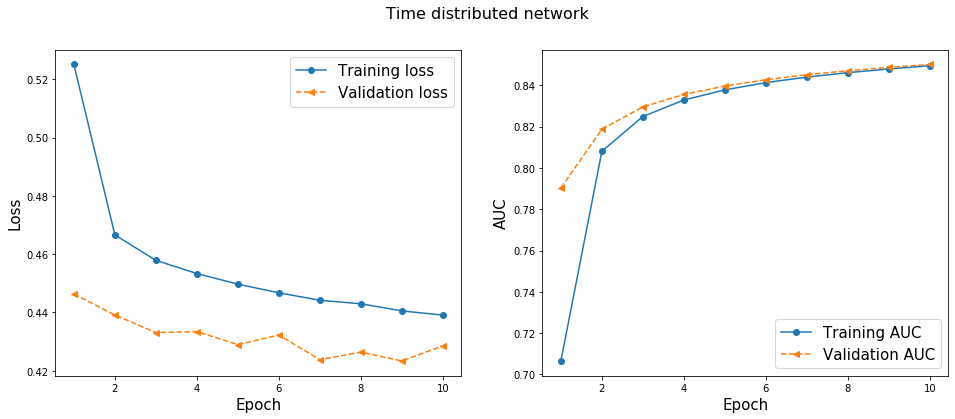

In [49]:
plot_train_valid(one_shot_model_history, 'Time distributed network')

#Performance on the test set.

In [0]:
test_data_features=test[['char_match_count','word_match_count','cosine_similarity']]
y_pred = one_shot_model.predict([sequences_test_q1_padded, 
                                 sequences_test_q2_padded,
                                 test_data_features])

In [40]:
classification_and_confusion_report(test.is_duplicate,y_pred,0.5)

[[21410  3972]
 [ 4804 10139]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     25382
           1       0.72      0.68      0.70     14943

    accuracy                           0.78     40325
   macro avg       0.77      0.76      0.76     40325
weighted avg       0.78      0.78      0.78     40325



# One shot learning using Siamese network with LSTM layer and Manhattan similarity.

In [0]:
def exponent_neg_manhattan_distance(left, right):
    '''Define Manhattan diastance. '''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [0]:
K.clear_session()
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Flatten
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

features  = Input(shape=(3,))

q1 = Embedding(NB_WORDS + 1, 
               EMBEDDING_DIM, 
               weights=[word_embedding_matrix], 
               input_length=MAX_SEQUENCE_LENGTH, 
               trainable=True)(question1)

q2 = Embedding(NB_WORDS + 1, 
               EMBEDDING_DIM, 
               weights=[word_embedding_matrix], 
               input_length=MAX_SEQUENCE_LENGTH, 
               trainable=True)(question2)

# shared LSTM
shared_lstm = Bidirectional(LSTM(30), merge_mode = 'sum')

q1 = shared_lstm(q1)
q2 = shared_lstm(q2)

malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                         output_shape=lambda x: (x[0][0], 1))([q1,q2])

#functional keras code instead of the normal sequential code
merged = concatenate([malstm_distance,
                      features])
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(50, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

one_shot_lstm_model = Model(inputs=[question1,question2,features], 
                            outputs=is_duplicate)

auc_roc = as_keras_metric(tf.metrics.auc)
one_shot_lstm_model.compile(loss='binary_crossentropy', 
                            optimizer='adam', 
                            metrics=[auc_roc])

In [0]:
train_features=train[['char_match_count','word_match_count','cosine_similarity']]

In [44]:
deprecation._PRINT_DEPRECATION_WARNINGS = False
one_shot_lstm_model_history = one_shot_lstm_model.fit([sequences_train_q1_padded, 
                                                       sequences_train_q2_padded,
                                                       train_features],
                                                      train.is_duplicate,
                                                      epochs=NB_EPOCHS,
                                                      validation_split=VALIDATION_SPLIT,
                                                      batch_size=BATCH_SIZE,
                                                      initial_epoch = 0)

Train on 327565 samples, validate on 36397 samples
Epoch 1/10
327565/327565 [==============================] - 1335s 4ms/step - loss: 0.4828 - auc: 0.7831 - val_loss: 0.4275 - val_auc: 0.8287
Epoch 2/10
327565/327565 [==============================] - 1332s 4ms/step - loss: 0.4324 - auc: 0.8414 - val_loss: 0.4039 - val_auc: 0.8499
Epoch 3/10
327565/327565 [==============================] - 1335s 4ms/step - loss: 0.4120 - auc: 0.8564 - val_loss: 0.4011 - val_auc: 0.8613
Epoch 4/10
327565/327565 [==============================] - 1361s 4ms/step - loss: 0.3961 - auc: 0.8658 - val_loss: 0.3966 - val_auc: 0.8694
Epoch 5/10
327565/327565 [==============================] - 1381s 4ms/step - loss: 0.3823 - auc: 0.8730 - val_loss: 0.3961 - val_auc: 0.8758
Epoch 6/10
327565/327565 [==============================] - 1388s 4ms/step - loss: 0.4375 - auc: 0.8753 - val_loss: 0.4418 - val_auc: 0.8741
Epoch 7/10
327565/327565 [==============================] - 1397s 4ms/step - loss: 0.4247 - auc: 0.8739

# Training - validation plots (LSTM).

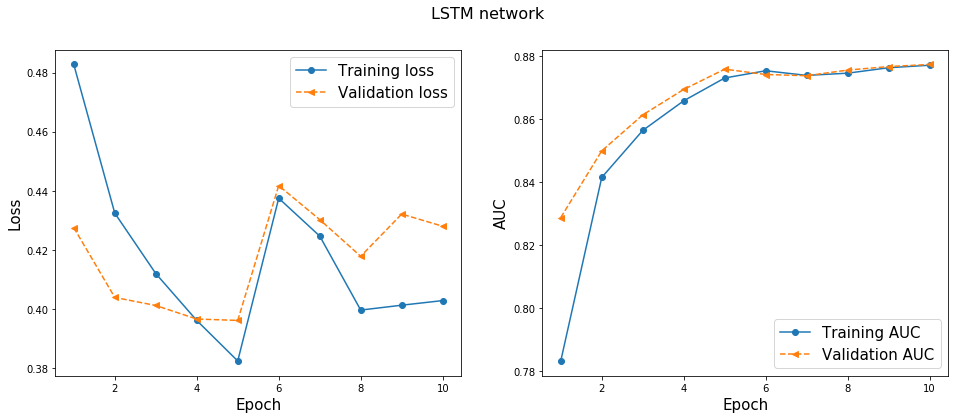

In [50]:
plot_train_valid(one_shot_lstm_model_history, 'LSTM network')

# Performance on the test set (LSTM).

In [0]:
test_data_features=test[['char_match_count','word_match_count','cosine_similarity']]
y_pred_lstm = one_shot_lstm_model.predict([sequences_test_q1_padded, 
                                           sequences_test_q2_padded,
                                           test_data_features])

In [55]:
classification_and_confusion_report(test.is_duplicate,y_pred_lstm,0.5)

[[22111  3271]
 [ 5278  9665]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     25382
           1       0.75      0.65      0.69     14943

    accuracy                           0.79     40325
   macro avg       0.78      0.76      0.77     40325
weighted avg       0.79      0.79      0.78     40325

